# Run and process the prior monte carlo and pick a "truth" realization

In [75]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [76]:
t_d = "template"
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))

### run the prior ensemble in parallel locally

In [77]:
m_d = "master_prior_sweep"
#pyemu.os_utils.start_slaves(t_d,"pestpp-swp","freyberg.pst",num_slaves=20,slave_root=".",master_dir=m_d)

### Load the output ensemble and plot a few things

The observations with the `fa_hw` tag are "flow aquifer" outputs from the SFR ASCII output file and the `hw` is for the "headwaters" cumulative flow aquifer for the upper 20 reaches

In [78]:
obs = pst.observation_data
swgw = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
swgw

obsnme
fa_hw_19791230    fa_hw_19791230
fa_hw_19801229    fa_hw_19801229
Name: obsnme, dtype: object

Two forecasts - one during the historical period, and one during the scenario period

In [79]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
obs_df.shape

(200, 4461)

drop any failed runs

In [80]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
obs_df.shape

(200, 4461)

In [81]:
#obs_df.phi.apply(np.log10).hist(bins=20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x181b1da5c0>,
      dtype=object)

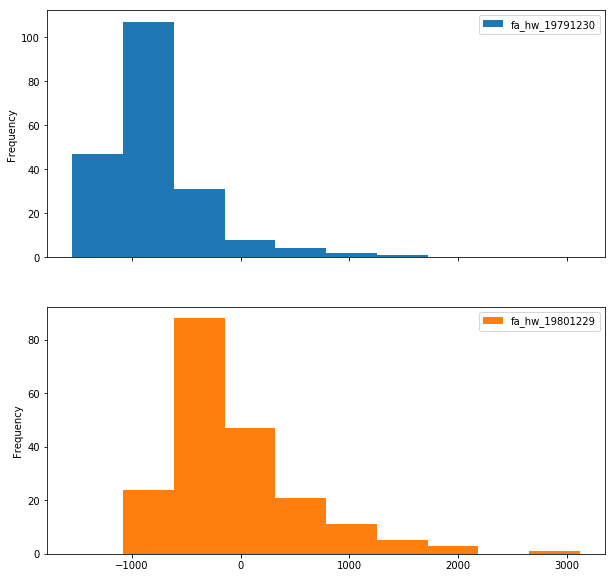

In [82]:
obs_df.loc[:,swgw].plot(kind="hist",subplots=True,figsize=(10,10))

We see that under scenario conditions, many more realizations for the flow to the aquifer in the headwaters are postive (as expected).  Lets difference these two:

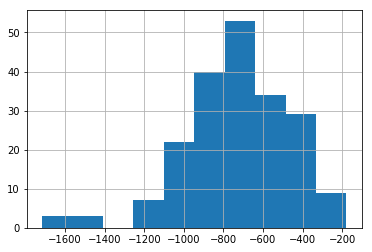

In [83]:
diff = obs_df.loc[:,swgw[0]] - obs_df.loc[:,swgw[1]]
diff.hist()

We now see that the most extreme scenario yields a large decrease in flow from the aquifer to the headwaters (the most negative value)

In [84]:
diff_sort = diff.sort_values()
diff_sort.head()

run_id
67    -1716.900716
63    -1624.352450
182   -1574.195200
163   -1533.029090
54    -1445.568200
dtype: float64

We just need to replace the observed values (`obsval`) in the control file with the outputs for one of the realizations on `obs_df`.  In this way, we now have the nonzero values for history matching, but also the ``truth`` values for comparing how we are doing with other unobserved quantities.  Im going to pick a realization that yields an "average" variability of the observed gw levels:

In [85]:
# choose the realization with largest historic gw to sw flux
hist_swgw = obs_df.loc[:,swgw[0]].sort_values()
idx = hist_swgw.index[0]

In [86]:
obs_df.loc[idx,pst.nnz_obs_names]

hds_00_002_009_000    35.726109
hds_00_002_015_000    34.688915
hds_00_003_008_000    35.809399
hds_00_009_001_000    36.674793
hds_00_013_010_000    34.991371
hds_00_015_016_000    34.756569
hds_00_021_010_000    34.980972
hds_00_022_015_000    34.717842
hds_00_024_004_000    36.114929
hds_00_026_006_000    35.601357
hds_00_029_015_000    34.264172
hds_00_033_007_000    34.888523
hds_00_034_010_000    34.302498
Name: 35, dtype: float64

Lets see how our selected truth does with the swgw forecasts:

In [87]:
print(obs_df.loc[idx,swgw])
print(diff_sort.loc[idx])

fa_hw_19791230   -1548.73080
fa_hw_19801229    -871.26612
Name: 35, dtype: float64
-677.4646800000002


In [88]:
pst.observation_data.loc[:,"obsval"] = obs_df.loc[idx,pst.obs_names]
pst.observation_data.loc[pst.nnz_obs_names,"weight"] = 10.0

Now, it is custom to add noise to the observed values...we will use the classic Gaussian noise...zero mean and standard deviation of 1 over the weight

In [89]:
# np.random.seed = 0
# print(np.random.seed)
# std = 1.0 / pst.observation_data.loc[pst.nnz_obs_names,"weight"].mean()
# noise = np.random.normal(0,std,size=pst.nnz_obs)
# pst.observation_data.loc[pst.nnz_obs_names,"obsval"] += noise

In [90]:
pst.write(os.path.join(t_d,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=t_d)

In [91]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

1394.7449962141293


,name,group,measured,modelled,residual,weight
name,,,,,,
hds_00_002_009_000,hds_00_002_009_000,calhead,35.726109,37.107498,-1.381390,10.0
hds_00_002_015_000,hds_00_002_015_000,calhead,34.688915,35.045185,-0.356270,10.0
hds_00_003_008_000,hds_00_003_008_000,calhead,35.809399,37.397289,-1.587891,10.0
hds_00_009_001_000,hds_00_009_001_000,calhead,36.674793,39.546417,-2.871624,10.0
hds_00_013_010_000,hds_00_013_010_000,calhead,34.991371,35.571774,-0.580402,10.0
hds_00_015_016_000,hds_00_015_016_000,calhead,34.756569,34.835716,-0.079147,10.0
hds_00_021_010_000,hds_00_021_010_000,calhead,34.980972,35.386250,-0.405277,10.0
hds_00_022_015_000,hds_00_022_015_000,calhead,34.717842,34.577492,0.140350,10.0
hds_00_024_004_000,hds_00_024_004_000,calhead,36.114929,36.760464,-0.645535,10.0


Just to make sure we have everything working right, we should be able to load the truth parameters, run the model once and have a (near-)zero `phi`:

In [92]:
par_df = pd.read_csv(os.path.join(m_d,"sweep_in.csv"),index_col=0)
pst.parameter_data.loc[:,"parval1"] = par_df.loc[idx,pst.par_names]
pst.write(os.path.join(m_d,"test.pst"))
pyemu.os_utils.run("pestpp-ies.exe test.pst",cwd=m_d)

In [93]:
pst = pyemu.Pst(os.path.join(m_d,"test.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

8.028325152762286e-17


,name,group,measured,modelled,residual,weight
name,,,,,,
hds_00_002_009_000,hds_00_002_009_000,calhead,35.726109,35.726109,-2.538769e-11,10.0
hds_00_002_015_000,hds_00_002_015_000,calhead,34.688915,34.688915,3.144507e-10,10.0
hds_00_003_008_000,hds_00_003_008_000,calhead,35.809399,35.809399,-1.230447e-10,10.0
hds_00_009_001_000,hds_00_009_001_000,calhead,36.674793,36.674793,-4.081997e-10,10.0
hds_00_013_010_000,hds_00_013_010_000,calhead,34.991371,34.991371,2.148468e-10,10.0
hds_00_015_016_000,hds_00_015_016_000,calhead,34.756569,34.756569,3.085958e-10,10.0
hds_00_021_010_000,hds_00_021_010_000,calhead,34.980972,34.980972,-3.906564e-11,10.0
hds_00_022_015_000,hds_00_022_015_000,calhead,34.717842,34.717842,-5.078249e-11,10.0
hds_00_024_004_000,hds_00_024_004_000,calhead,36.114929,36.114929,-2.187477e-10,10.0


Lets load the model and check some things

In [94]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=m_d)

6.72255e-05 8.555651e-05


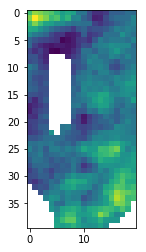

In [95]:
#a = m.upw.hk[0].array
a = m.rch.rech[0].array
a = np.ma.masked_where(m.bas6.ibound[0].array==0,a)
print(a.min(),a.max())
plt.imshow(a)

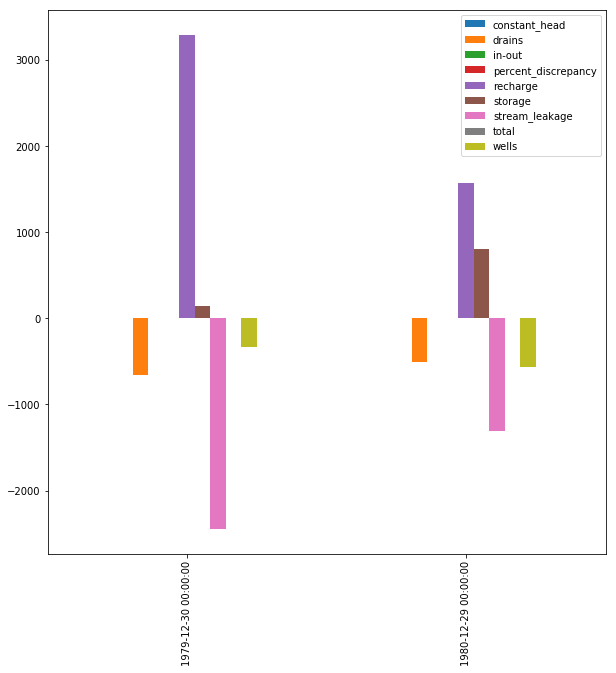

In [96]:
lst = flopy.utils.MfListBudget(os.path.join(m_d,"freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
df.plot(kind="bar",figsize=(10,10))